In [2]:
from transformers import GPT2LMHeadModel

In [5]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [29]:
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [33]:
sd_hf["transformer.wpe.weight"].view(-1).shape

torch.Size([786432])

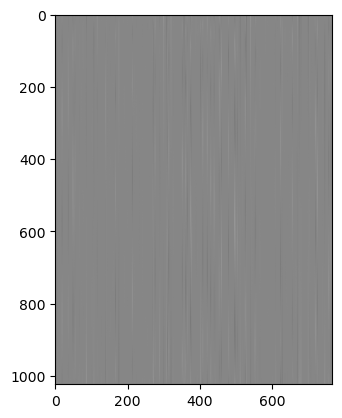

In [39]:
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

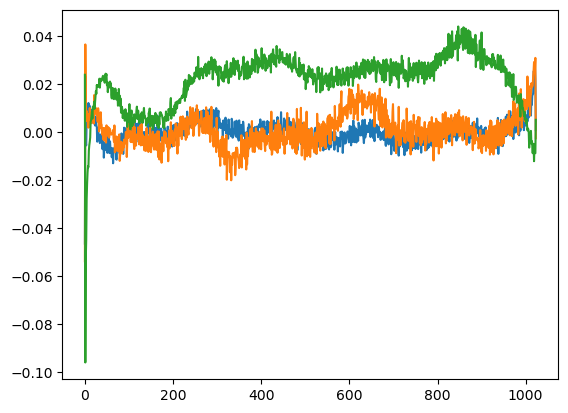

In [55]:
# sd_hf["transformer.wpe.weight"][:, 150] # --> channel 150 looking across every position

plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250]) # "This green channel likes to fire for everything up to about position 900

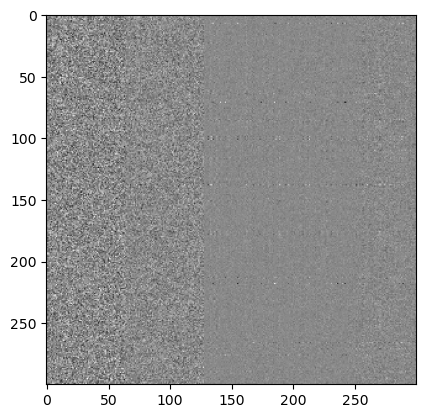

In [91]:
plt.imshow(sd_hf['transformer.h.1.attn.c_attn.weight'][:300,:300], cmap="gray")

In [199]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, truncation=True, num_return_sequences=5)

Device set to use mps:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, and my project will get better with time, but I think there are a lot more things that can help you"},
 {'generated_text': "Hello, I'm a language model, not a language model, so if I don't have a problem, I can fix it by creating new words"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to learn some stuff. I'll try to do some basic programming and just learn better ways"},
 {'generated_text': "Hello, I'm a language model, but I don't believe in grammar. This will work for every language model. You can define it very quickly"},
 {'generated_text': 'Hello, I\'m a language model, a model of how things should be, and then we look at different things as well." I\'d like to'}]

In [102]:
import torch
import torch.nn as nn

In [106]:
class GPT(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(50000, 768),
            wpe = nn.Embedding(1024, 768),
            h = nn.ModuleList([]),
            ln_f = nn.LayerNorm(768)
        ))

In [121]:
qkv = torch.randn(4, 8, 3 * 768)
q, k, v = qkv.split(768, dim=2)
q.shape

torch.Size([4, 8, 768])

In [122]:
768 // 6

128

In [186]:
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

# ----------------------------------------------------------

class CausalSelfAttention(nn.Module):

	def __init__(self, config):
		super().__init__()
		assert config.n_embd % config.n_head == 0

		self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # key, query, value projections for all heads but in a batch. Saves you from three separate instantiations of nn.Linear
		self.c_proj = nn.Linear(config.n_embd, config.n_embd) # output projection

		self.n_head = config.n_head
		self.n_embd = config.n_embd

		self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

	def forward(self, x):

		B, T, C = x.size() # batch size, sequence length, embedding dimension (n_embd)

		# Calculate query, key, value for all heads in batch, move head forward in the shape to be a batch dim alongside B
		# nh is "number of heads", hs is "head size", and C is number of channels (nh * hs)
		# e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs = 768 channels in the Transformer

		qkv = self.c_attn(x)
		q, k, v = qkv.split(self.n_embd, dim=2)
		k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

		# attention materializes the large (T, T) matrix for all queries and keys
		att = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))) # --> (B, nh, T, T)
		att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
		att = F.softmax(att, dim=-1)

		y = att @ v # (B, nh, T, T) x (B, nh, T, hs) --> (B, nh, T, hs)
		y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

		# output project
		y = self.proj(y)
		return y



class MLP(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # On naming (eg 'c_fc'), we are replicating the GPT2 model
		self.gelu = nn.GELU(approximate='tanh')
		self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)

	def forward(self, x):
		x = self.c_fc(x)
		x = self.gelu(x)
		x = self.c_proj(x)
		return x


class Block(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.ln_1 = nn.LayerNorm(config.n_embd)
		self.attn = CausalSelfAttention(config)
		self.ln_2 = nn.LayerNorm(config.n_embd)
		self.mlp = MLP(config)		

	def forward(self, x):
		x = x + self.attn(self.ln_1(x))
		x = x + self.mlp(self.ln_2(x)) 
		return x



@dataclass
class GPTConfig:
	block_size: int = 1024 # max sequence length
	vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
	n_layer: int = 12 # number of layers
	n_head: int = 12 # number of heads
	n_embd: int = 768 # embedding dimension

class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


In [187]:
config = GPTConfig
model = GPT(config)
model

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [189]:
x = torch.randn(4, 8)
sd_keys = model.state_dict().keys()
sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]
len(sd_keys)
# sd_keys

149

In [190]:
sd_hf
sd_keys_hf = sd_hf.keys()
sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # dicard the mask / buffer
sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # dicard the mask / buffer
len(sd_keys_hf)
# sd_keys_hf

149

In [195]:
model.transformer.h[0]

Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): CausalSelfAttention(
    (c_attn): Linear(in_features=768, out_features=2304, bias=True)
    (c_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (c_fc): Linear(in_features=768, out_features=3072, bias=True)
    (gelu): GELU(approximate='tanh')
    (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  )
)

In [197]:
x.device

device(type='cpu')

In [208]:
# torch.cuda.get_device_name(0)

In [222]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
tokens

tensor([[15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11],
        [15496,    11,   314,  1101,   257,  3303,  2746,    11]])